#**TextVectorization() Layer**

#*How It Works*

The TextVectorization() layer in Keras automates / simplifies much of the textual pre-processing we might want to do. By default, it simply changes all text to lowercase, removes punctuation, and splits into 1-grams based on white space. Some integers are reserved in the resulting encoding. Most notably, the value of 1 is reserved for tokens that did not appear in the original corpus that was used to construct the integer encoding ([UNK]). A code of 0 is reserved for an "ignore" flag, identified by a masking layer.

In [1]:
import tensorflow as tf
import string
import re
from tensorflow import keras

def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor) # We convert upper case characters to lowercase.
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", "") # We find and remove punctuation.
  
def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor) # By default the separator is white space.
 
text_vectorization = keras.layers.TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
)

dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]

text_vectorization.adapt(dataset)
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 'erase',
 'write',
 'then',
 'rewrite',
 'poppy',
 'i',
 'blooms',
 'and',
 'again',
 'a']

Let's try using this layer to encode a sentence.

In [2]:
vocabulary = text_vectorization.get_vocabulary()

test_sentence = "I like to write practice sentences about a poppy that blooms again and again..." 
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence.numpy())

inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

[ 7  1  1  3  1  1  1 11  6  1  8 10  9 10]
i [UNK] [UNK] write [UNK] [UNK] [UNK] a poppy [UNK] blooms again and again


#*Incorporating Into TF Dataset Pipeline*

There is a textfile equivalent function to what we'd seen previously for image data, called text_dataset_from_directory(). The folder structure works the same way as before and individual observations / documents should appear as separate .txt files in the folder. 

Let's try this out using the IMDB Review dataset (an un-processed copy of it)...

In [3]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup
!cat aclImdb/train/pos/4077_10.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  43.3M      0  0:00:01  0:00:01 --:--:-- 43.3M
I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drin

We now have the root folder with test and train directories. Inside each of those directories we have neg and pos subdirectories, which in turn contain lots of .txt files (one per movie review).

In [6]:
!ls aclImdb/test/neg

0_2.txt      11874_4.txt  2500_2.txt  4376_1.txt  6252_1.txt  8128_4.txt
10000_4.txt  11875_3.txt  2501_3.txt  4377_4.txt  625_2.txt   8129_4.txt
10001_1.txt  11876_4.txt  250_1.txt   4378_4.txt  6253_1.txt  8130_4.txt
10002_3.txt  11877_1.txt  2502_1.txt  4379_4.txt  6254_4.txt  8131_1.txt
10003_3.txt  11878_3.txt  2503_3.txt  4380_3.txt  6255_1.txt  813_1.txt
1000_3.txt   11879_2.txt  2504_3.txt  4381_3.txt  6256_2.txt  8132_3.txt
10004_2.txt  11880_3.txt  2505_1.txt  4382_3.txt  6257_4.txt  8133_4.txt
10005_2.txt  11881_2.txt  2506_1.txt  438_2.txt   6258_2.txt  8134_2.txt
10006_2.txt  11882_2.txt  2507_1.txt  4383_4.txt  6259_4.txt  8135_1.txt
10007_4.txt  1188_2.txt   2508_1.txt  4384_1.txt  6260_2.txt  8136_4.txt
10008_4.txt  11883_4.txt  2509_1.txt  4385_2.txt  6261_1.txt  8137_1.txt
10009_3.txt  11884_2.txt  2510_3.txt  4386_1.txt  6262_4.txt  8138_2.txt
10010_2.txt  11885_1.txt  2511_4.txt  4387_1.txt  6263_2.txt  8139_4.txt
10011_1.txt  11886_1.txt  2512_2.txt  4388_3.txt  62

Here, we are going to start by creating a validation sample (so we have train, validation and test). To do this, we will siphon off 20% of the files in each category (pos and neg), and put them into a new folder (validation). We will first shuffle the files before selecting which ones to copy.

In [7]:
import os, pathlib, shutil, random
  
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val" 
train_dir = base_dir / "train" 
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

Now we can make our text datasets... 

In [8]:
from tensorflow import keras
batch_size = 32 
  
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Let's see what these datasets look like. Each batch of inputs is a set of 32 observations. Each observation is a string tensor. We have 32 labels for our 32 strings, which are 1-0 binary integer values.

In [ ]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape) # We have 32 reviews per batch.
    print("inputs.dtype:", inputs.dtype) # They are strings.
    print("targets.shape:", targets.shape) # We have 32 labels per batch.
    print("targets.dtype:", targets.dtype) # They are integers.
    print("inputs[0]:", inputs[0]) # Here is the first example
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b"I love to watch this movie a lot because of all the scary scenes about the raptors. I like raptors because they are scary. My favorite parts are the ones where the raptor looks behind the pillar because it reminds me of a scene from the Friday the 13th movie with the girl who eats the banana.<br /><br />I really love to watch a lot of this movie because the computer graphics seem a little fake but it's okay because once you get into the movie you hardly even notice what is going on and I think it's got a good ending even though I didn't really understand what was going on on my first couple viewings I figured it out over time and that's the important part. The other important part is how scary the dinosaurs can be if you're watching it the first time.<br /><br />THIS IS BEST MOVIE.", shape=(), dtype=string)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


Now we can apply our TextVectorization layer to the datasets. We are processing all the text ahead of time in the TF Dataset object, rather than processing it inside our network during the training process, because it will be faster. 

In [21]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot", # This is requesting multihot encodings, so we are taking a bag of words approach.
    # output_mode="count", # Using this instead I can get term frequencies. 
    # output_mode="tf_idf", # Using this gives me IDF weighted term counts
)

text_only_train_ds = train_ds.map(lambda x, y: x) # This lambda function will just return the text sample for each observation and drop the label.
text_vectorization.adapt(text_only_train_ds) # We can then apply our vectorizer to this corpus of data, and it will create the vocabulary, etc.
 
binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), # Then we can apply the resulting vectorizer to the dataset, again via lambda function.
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Now each *new* dataset yields vectorized / processed versions of the observation's text, and the associated label. Our 1-gram multi-hot encoded representation is a matrix with 20k columns, 1's and 0's for word presence. 

In [20]:
for x, y in train_ds:
  print(x[0])
  break

for x, y in binary_1gram_train_ds:
  print(x[0]) 
  break

tf.Tensor(b'I have seen it & i like it Melissa plays her part well. It was actually believable. My brother in law saw it with my sister & i and when i mentioned to my sister that i forgot it was based on a true story (i had seen it a few years ago.) he said just because its on lifetime you think its true & both my sister & i were like it was so anyway i was wondering if anyone knew what murder it was or like who was really involved was because i want to prove it to him. I love lifetime movies especially the ones that are true, or just the ones that teach a good lesson. I thought I saw something about it a week ago but i cant remember where any help would be appreciated.', shape=(), dtype=string)
tf.Tensor([25.790615  12.554096   2.1296473 ...  0.         0.         0.       ], shape=(20000,), dtype=float32)


#*Train a Model*

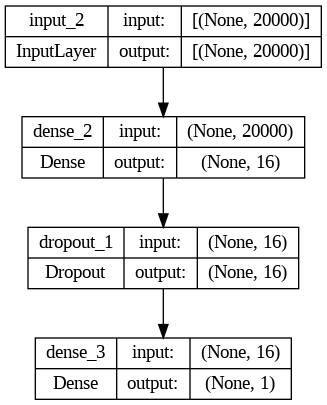

In [23]:
inputs = keras.Input(shape=(20000,)) # Here we have 20k columns as input for each observation.
x = keras.layers.Dense(16, activation="relu")(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

keras.utils.plot_model(model,show_shapes=True)

And, now we can train and then test the model...

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]

history = model.fit(binary_1gram_train_ds.cache(),  # Note: using .cache will make it so file opening and data reading are up front, not during each epoch
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

model = keras.models.load_model("binary_1gram.keras") 

print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 11s 17ms/step - loss: 0.4128 - accuracy: 0.8259 - val_loss: 0.2973 - val_accuracy: 0.8844
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2809 - accuracy: 0.8967 - val_loss: 0.2928 - val_accuracy: 0.8880
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2490 - accuracy: 0.9101 - val_loss: 0.3035 - val_accuracy: 0.8884
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2353 - accuracy: 0.9196 - val_loss: 0.3144 - val_accuracy: 0.8882
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2250 - accuracy: 0.9268 - val_loss: 0.3289 - val_accuracy: 0.8890
Epoch 6/10
625/625 [==============================] - 5s 9ms/step - loss: 0.2231 - accuracy: 0.9297 - val_loss: 0.3394 - val_accuracy: 0.8820
Epoch 7/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2150 - accuracy: 0.9326 - val_loss: 0.3504 - val_accuracy: 0.8838
Epoc

#*Bigrams, TF-IDF, etc.*

Let's try this again, but with a bit of sequence information. We'll incorporate bi-grams (note that we had done this before, manually).

In [ ]:
text_vectorization_bigram = keras.layers.TextVectorization(
    max_tokens=20000, # adding more tokens to allow for increase due to bigrams.
    output_mode="multi_hot", # This is requesting hot encodings; to get term counts we could request "count" as the output mode, and tf-idf using "tf-idf"
    ngrams=2 # We could also do (1,2) here for both unigrams AND bigrams
)

text_only_train_ds = train_ds.map(lambda x, y: x) # This lambda function will just return the text sample for each observation and drop the label.
text_vectorization_bigram.adapt(text_only_train_ds) # We can then apply our vectorizer to this corpus of data, and it will create the vocabulary, etc.
 
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization_bigram(x), y), # Then we can apply the resulting vectorizer to the dataset, again via lambda function.
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization_bigram(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization_bigram(x), y),
    num_parallel_calls=4)

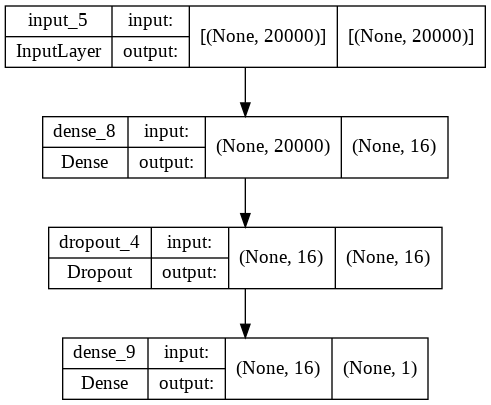

In [ ]:
max_tokens=20000
hidden_dim=16

inputs = keras.Input(shape=(max_tokens,))
x = keras.layers.Dense(hidden_dim, activation="relu")(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

keras.utils.plot_model(model,show_shapes=True)

We do 1.5-2% better in our test accuracy when we add in the bigrams. But, ultimately, the bigrams are only a crude representation of sequence information. We need to switch to proper sequence models to (potentially) do better.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]

history = model.fit(binary_2gram_train_ds.cache(),  # Note: using .cache will make it so file opening and data reading are up front, not during each epoch
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

model = keras.models.load_model("binary_2gram.keras") 

print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 8s 13ms/step - loss: 0.4054 - accuracy: 0.8282 - val_loss: 0.3087 - val_accuracy: 0.8804
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2712 - accuracy: 0.9087 - val_loss: 0.3129 - val_accuracy: 0.8846
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2351 - accuracy: 0.9230 - val_loss: 0.3367 - val_accuracy: 0.8852
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2229 - accuracy: 0.9295 - val_loss: 0.3578 - val_accuracy: 0.8802
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2157 - accuracy: 0.9330 - val_loss: 0.3771 - val_accuracy: 0.8792
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2075 - accuracy: 0.9365 - val_loss: 0.3815 - val_accuracy: 0.8748
Epoch 7/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2016 - accuracy: 0.9383 - val_loss: 0.4240 - val_accuracy: 0.8736
Epoch

#*Without TF Dataset Pipelines*

Let's say we just want to work with text data in memory... we can do that too... going back to our simple example... note that training will be slower if we do this because TextVectorization happens on the CPU. Typically approach is to use TF Datasets, pre-process the data for training, then take the final model and add the same pre-processing steps as layers at the end, to be able to pass raw text as input and get the associated predictions as output. 

In [ ]:
import numpy as np 

dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]

dataset = np.stack(dataset).reshape(3,1)
labels = np.array([1, 0, 1])

(3, 1)


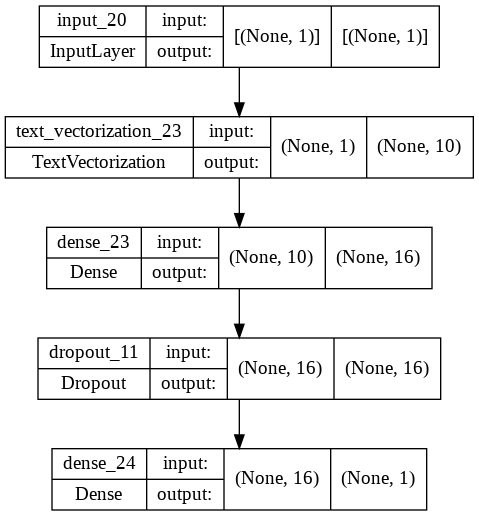

In [ ]:
text_vectorization_bigram = keras.layers.TextVectorization(
    max_tokens=10, # adding more tokens to allow for increase due to bigrams.
    output_mode="multi_hot", # This is requesting hot encodings; to get term counts we could request "count" as the output mode, and tf-idf using "tf-idf"
    ngrams=2 # We could also do (1,2) here for both unigrams AND bigrams
)

text_vectorization_bigram.adapt(dataset)

inputs = keras.Input(shape=(1), dtype=tf.string) # Be careful! You need to specify a string datatype here, or the model will produce errors when you go to fit. 
processing = text_vectorization_bigram(inputs)
x = keras.layers.Dense(hidden_dim, activation="relu")(processing)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.fit(dataset,labels,batch_size=1,epochs=2)

Epoch 1/2
3/3 [==============================] - 1s 4ms/step - loss: 0.7142 - accuracy: 0.3333
Epoch 2/2
3/3 [==============================] - 0s 5ms/step - loss: 0.5424 - accuracy: 0.6667
